# Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

Цель: При управлении нагревом можно будет подставлять разные параметры и смотреть на результат. И корректировать параметры так, чтобы избегать лишнего нагрева.
Обратная задача (предсказать параметры по температуре) слишком сложная, поэтому не рассматриваем.
Можно сказать, что с помощью модели будет происходить имитация технологического процесса. Т.е. мы с можем воспроизводить процесс(эксперимент) с помощью математической модели, и тестировать только лучшие результаты, также можем выделить наиболее важные признаки влияющие на нагрев и конечную температуру.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

1. Из сплава выводится сера (этот процесс — десульфурация), 
2. Добавлением примесей корректируется химический состав и 
3. Отбираются пробы. 
4. Измеряют температуру стали и производят её химический анализ.
5. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом
6. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
7. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

2 измерения температуры и 1 повышение температуры

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).


## Описание даных 
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).

# Загрузка данных

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from catboost import Pool, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.dummy import DummyRegressor


from sklearn.metrics import mean_absolute_error


In [151]:
# Функция для импорта данных с заданными путями
def import_data(path_list):
    for path in path_list:
        try:
            data = pd.read_csv(path)
            return data
        except FileNotFoundError:
            pass
    raise FileNotFoundError("Проверьте правильность пути к данным")

# Импорт данных об электродах
pth1 = ['data_arc_new.csv', '/datasets/data_arc_new.csv', 'https://code.s3.yandex.net/datasets/data_arc_new.csv']
data_arc_new = import_data(pth1)

# Импорт данных о подаче сыпучих материалов (объём)
pth2 = ['data_bulk_new.csv', '/datasets/data_bulk_new.csv', 'https://code.s3.yandex.net/datasets/data_bulk_new.csv']
data_bulk_new = import_data(pth2)

# Импорт данных о подаче сыпучих материалов (время)
pth3 = ['data_bulk_time_new.csv', '/datasets/data_bulk_time_new.csv', 'https://code.s3.yandex.net/datasets/data_bulk_time_new.csv']
data_bulk_time_new = import_data(pth3)

# Импорт данных о продувке сплава газом
pth4 = ['data_gas_new.csv', '/datasets/data_gas_new.csv', 'https://code.s3.yandex.net/datasets/data_gas_new.csv']
data_gas_new = import_data(pth4)

# Импорт данных о результаты измерения температуры
pth5 = ['data_temp_new.csv', '/datasets/data_temp_new.csv', 'https://code.s3.yandex.net/datasets/data_temp_new.csv']
data_temp_new = import_data(pth5)

# Импорт данных о проволочных материалах (объём)
pth6 = ['data_wire_new.csv', '/datasets/data_wire_new.csv', 'https://code.s3.yandex.net/datasets/data_wire_new.csv']
data_wire_new = import_data(pth6)

# Импорт данных о проволочных материалах (время)
pth7 = ['data_wire_time_new.csv', '/datasets/data_wire_time_new.csv', 'https://code.s3.yandex.net/datasets/data_wire_time_new.csv']
data_wire_time_new = import_data(pth7)

# Анализ и предобработка данных

In [152]:
# напишем функцию для первичного осмотра данных
def analiz(data):
    display(data.head())
    display(data.describe())
    display(data.info())
    print('Строк с пустыми значениям: ', (data.isna().all(axis=1)).sum())
    print('Дуликатов в датасете: ', data[data.duplicated()].shape[0])
    print('Пропущенных значений в столбцах: ', data.isna().sum())

## Данные об электродах - data_arc_new

In [153]:
analiz(data_arc_new)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


### Вывод:
Столбцы со временем имеют тип object. Отмечаем наличие аномально низкого значение (-715) в столбце 'Реактивная мощность'.


In [154]:
# Приведем в порядок названия столбцов и тип формата данных
data_arc_new.columns = ['key','start_time', 'end_time', 'act_power', 'react_power']
data_arc_new[data_arc_new.columns[1:3]] = data_arc_new[data_arc_new.columns[1:3]].apply(pd.to_datetime)
# Посмотрим на выброс по ближе
data_arc_new.sort_values('react_power').head()

,key,start_time,end_time,act_power,react_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525


 Теоретически мощность может быть отрицательной, но в нашем случае сильно отрицательная мощность, это единичный случай, связанный скорей всего со сбоем измерительного оборудования. Удалять целую итерацию нежелательно, такчто просто заменим выброс средним.

In [155]:
data_arc_new[data_arc_new['key'] == 2116]

,key,start_time,end_time,act_power,react_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [156]:
# Заменяем выброс средним значением
data_arc_new.iloc[9780, 4] = (data_arc_new.iloc[9779, 4] + data_arc_new.iloc[9781, 4]) / 2

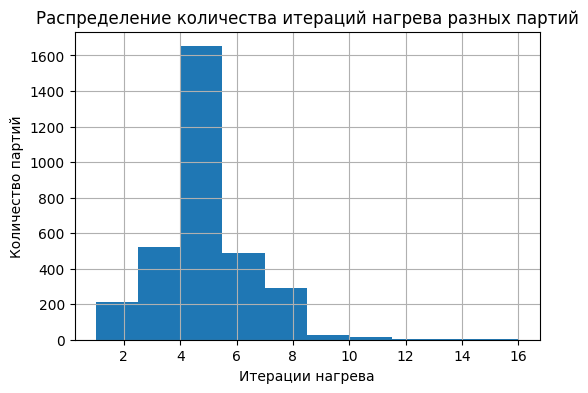

In [157]:
plt.figure(figsize=(6, 4))
data_arc_new.groupby('key')['act_power'].count().hist()
plt.title('Распределение количества итераций нагрева разных партий')
plt.ylabel('Количество партий')
plt.xlabel('Итерации нагрева')
plt.show()

Как мы видим у партий разное количество итераций нагрева, в дальнейшем можно будет использовать это как доп. признак.

Мощность необходимо с агрегировать по ключу, один ключ - одно наблюдение, с точки зрения физики мощность агрегатируется по среднему значению, но по сумме тоже можно агрегировать.

In [158]:
data_arc = data_arc_new.groupby('key').agg({'start_time': 'first',
                                            'end_time': 'last',
                                            'act_power': 'mean',
                                            'react_power': 'mean'}) \
                                            .reset_index()


## Данные о подаче сыпучих материалов - data_bulk_new и data_bulk_time_new


In [159]:
analiz(data_bulk_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


In [160]:
analiz(data_bulk_time_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


### Вывод:
В датасетах большое количество пропущенных данных в столбцах. Пропуски говорят о том, что добавки не добавлялись в данную партию. Данные в таблице со временем имеют тип object, приведем к datetime. В датасете со временем можно также увидеть хронологию добавления добавок или посчитать длительность которая занял процесс их добавления в качестче доп. признака.
Также обращает на себя внимание большая разница количестве даннных между столбцами: какие-то столбцы содержат десятки значений, какие-то сотни, иные тысячи. Необходимо посмотреть на них при помощи графика 

In [161]:
# Приведем названия столбцов и типы данных к норме
data_bulk_new.columns = data_bulk_new.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[0:]

data_bulk_time_new.columns = data_bulk_time_new.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[0:]
data_bulk_time_new[data_bulk_time_new.columns[1:]] = data_bulk_time_new[data_bulk_time_new.columns[1:]].apply(pd.to_datetime)


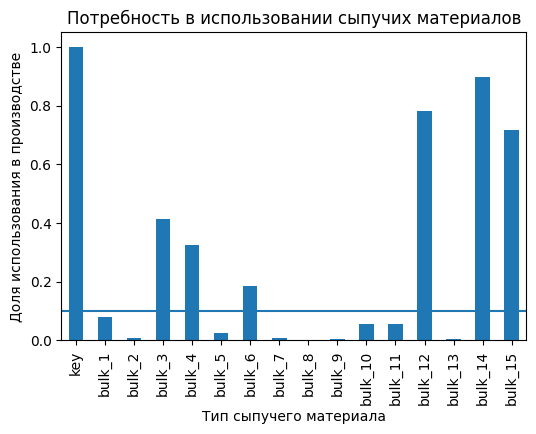

In [162]:
plt.figure(figsize=(6, 4))
(~data_bulk_new.isna()).mean().plot(kind='bar')
plt.ylabel('Доля использования в производстве')
plt.xlabel('Тип сыпучего материала')
plt.title('Потребность в использовании сыпучих материалов')
plt.axhline(y=0.1)
plt.show()

9 из 15 типов сыпучих материалов используются менее чем в 10 % партий.

In [163]:
data_bulk = data_bulk_new.copy()
data_bulk.fillna(0, inplace=True)

## Данные о продувке сплава газом - data_gas_new

In [164]:
analiz(data_gas_new)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  key      0
Газ 1    0
dtype: int64


Text(0.5, 0, 'Значение')

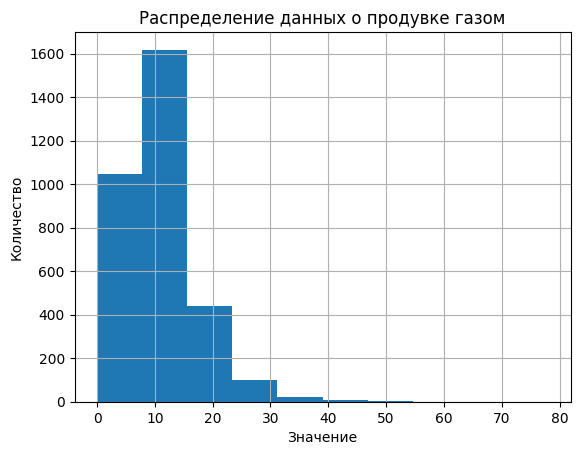

In [165]:
plt.figure()
data_gas_new['Газ 1'].hist()
plt.title('Распределение данных о продувке газом')
plt.ylabel('Количество')
plt.xlabel('Значение')

In [166]:
data_gas_new.sort_values('Газ 1', ascending=False).head(10)

,key,Газ 1
319,322,77.995040
277,280,60.935689
2107,2110,52.142373
2567,2570,51.380229
116,117,50.581035
2105,2108,45.638999
1461,1464,43.655411
660,663,41.854643
525,528,39.728826
610,613,39.425706


### Вывод:
Осмотр показал, что в датасете нет видимых проблем, кроме наименования столбцов. Скорее всего данные значения отвечают за длительность продувки сплава инертным газом

In [167]:
data_gas = data_gas_new.copy()
data_gas.columns = ['key', 'gas']

## Данные о результатах измерения температуры - data_temp_new

In [168]:
analiz(data_temp_new)
data_temp_new.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  key                0
Время замера       0
Температура     3427
dtype: int64


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Text(0.5, 0, 'Температура')

<Figure size 640x480 with 0 Axes>

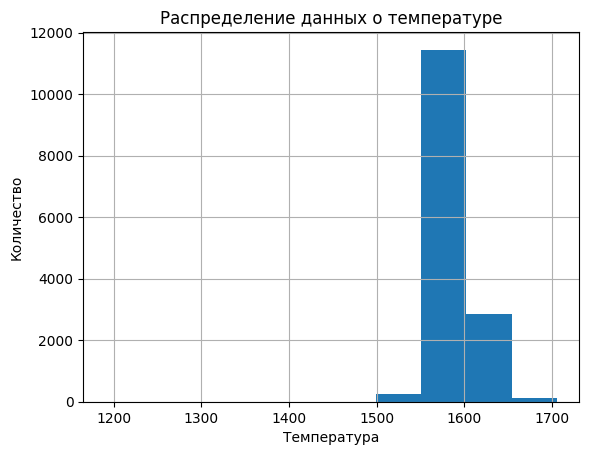

In [169]:
plt.figure()
data_temp_new.hist('Температура')
plt.title('Распределение данных о температуре')
plt.ylabel('Количество')
plt.xlabel('Температура')

In [170]:
data_temp_new.value_counts('key')

key
2108    17
1513    16
1689    16
2567    15
46      14
        ..
247      2
1169     2
246      2
195      1
279      1
Name: count, Length: 3216, dtype: int64

### Вывод

Датафрейм содержит целевой признак - последнее время измерения. Которое не должно быть меньше 1500 градусов.

На один ключ от 1 до 5 замеров. Имеются 3427 пропусков в грефе температуры. Ключи
* Первую температуру можем взять в качестве признака, т.к. она всегда известна.

Ключи с одним замером в финальную таблицу не берем, если будете использовать доп признак время нагрева

По информации от заказчика температура плавления нашего металла 1500 градусов, все что ниже аномалии, т.е. температуры ниже 1500 градусов не берем

* Приведем к норме названия столбцов и тип данных в них.
* Отберем ключи, в которых температура не меньше 1500 градусов в последнем измерении
* Создаем доп. признак - время нагрева в секундах, посчитав временные промежутки.
* Удаляем ключи, у которых только один замер. Их два, по ним не посчитать доп признак - время нагрева
* Создадим отдельный тренировочный датафрейм с первой температурой нагрева, временем нагрева и ключом. 
* Создадим целевой датафрейм в ключом и последней температурой нагрева.



In [171]:
data_temp_new[data_temp_new['key'] > 2500]


,key,Время замера,Температура
13931,2501,2019-08-10 14:41:14,1587.0
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [172]:
# Приводдим названия столбцов и типы данных в столбцах 
data_temp_new.columns = ['key','measure_time','temp']
data_temp_new['measure_time'] = pd.to_datetime(data_temp_new['measure_time'])
data_temp_new.fillna(0, inplace=True)
# Подсчет количества замеров для каждого ключа (наблюдения)
counts = data_temp_new['key'].value_counts()

# Оставление только тех наблюдений, у которых более одного замера
data_temp_new = data_temp_new[data_temp_new['key'].isin(counts[counts > 1].index)]

data_temp = data_temp_new.groupby('key').agg(last_time = ('measure_time', 'last'),
                                            first = ('temp', 'first'),
                                            last = ('temp', 'last')) \
                                            .reset_index()

data_temp = data_temp[(data_temp['last'] >= 1500)]
data_temp = data_temp[(data_temp['first'] >= 1500)]

print('Датафрейм с таргет-признаком содержит строк:', data_temp.shape[0])


Датафрейм с таргет-признаком содержит строк: 2471


В датафреймах о работе электронной дуги и времени измерений есть столбцы с времемнем. 
Оставим в датасете с таргет-признаками только те партии, время начала работы электронной дуги(start_time) в data_arc которых не позже последнего времени измерений(last_time) в data_temp

In [173]:
data_arc = data_arc[data_arc.index.isin(data_temp.index)]

# Фильтруем data_temp по времени начала работы электронной дуги
data_temp = data_temp[data_temp['last_time'] > data_arc['start_time']]

print('Датафрейм с таргет-признаком содержит строк:', data_temp.shape[0])
data_temp.drop('last_time', axis =1, inplace=True)

Датафрейм с таргет-признаком содержит строк: 2471


## Данные о проволочных материалах - data_wire_new и data_wire_time_new


In [174]:
analiz(data_wire_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


In [175]:
analiz(data_wire_time_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Строк с пустыми значениям:  0
Дуликатов в датасете:  0
Пропущенных значений в столбцах:  key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


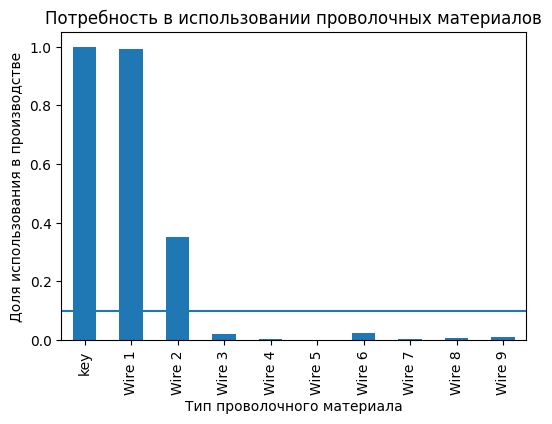

In [176]:
plt.figure(figsize = (6,4))
(~data_wire_new.isnull()).mean().plot(kind = 'bar')
plt.ylabel('Доля использования в производстве')
plt.xlabel('Тип проволочного материала')
plt.title('Потребность в использовании проволочных материалов')
plt.axhline(y=0.1)
plt.show()

### Вывод

Пропущенных значений в этом датаесете больше, чем в данных о сыпучих материалах. Можно сделать вывод, что проволочные материалы добавляются реже сыпучих. График наглядно демонстрирует, что всего 3 из 9 типов проволочных материалов активно используются в производстве. Их мы оставим, остальное - удалим.
Пропуски как и в случае сыпучих материалов говорят об отсутсвии этой добавки в партии.

In [177]:
#Приводим в порядок заголовки, типы даннных а также заполняем пропуски нулевыми значениями.
data_wire_new.columns = data_wire_new.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[0:]

data_wire_time_new.columns = data_wire_time_new.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[0:]
data_wire_time_new[data_wire_time_new.columns[1:]] = data_wire_time_new[data_wire_time_new.columns[1:]].apply(pd.to_datetime)
data_wire = data_wire_new.copy()
data_wire.fillna(0, inplace=True)

## Общий вывод

* Все таблицы с некорретными названиями признаков. 
* Также встречаются столбцы с неправильным типом данных, в основном в столбцах с датой.
* В данных встречаются выбросы из нормы и данные, которые представляют менее 10% от общего числа выборки.
* Данные о добаочных материалах содержат большое число пропусков. Мы заполнили их 0.

## Создаем дополнительные признаки

Для лучших показателей работы моделей машинного обучения необходимо создать новые признаки.

### Длительность процесса добавления сыпучих добавок

Добавим к основному датасету data_bulk

In [179]:
# Выбираем только столбцы с временем Bulk
time_columns = data_bulk_time_new.columns[1:]

# Создаем столбец с длительностью в секундах для каждой партии
data_bulk['duration_bulk'] = (data_bulk_time_new[time_columns].max(axis=1) - data_bulk_time_new[time_columns].min(axis=1)).dt.total_seconds()


### Длительность процесса добавления проволочных добавок

In [180]:
# Выбираем только столбцы с временем Bulk
time_columns = data_wire_time_new.columns[1:]

# Создаем столбец с длительностью в секундах для каждой партии
data_wire['duration_wire'] = (data_wire_time_new[time_columns].max(axis=1) - data_wire_time_new[time_columns].min(axis=1)).dt.total_seconds()


### Время нагрева электрической дугой

In [181]:
# Добавляем новый признак
data_arc['arc_heating_duration'] = (data_arc['end_time'] - data_arc['start_time']).dt.total_seconds()
# Удаляем datetime столбцы
data_arc.drop(['start_time', 'end_time'], axis=1, inplace=True)
data_arc

,key,act_power,react_power,arc_heating_duration
0,1,0.607346,0.428564,1583.0
1,2,0.534852,0.363339,1144.0
2,3,0.812728,0.587491,1525.0
3,4,0.676622,0.514248,1093.0
4,5,0.563238,0.421998,1362.0
...,...,...,...,...
2470,2495,0.792033,0.552734,1208.0
2471,2496,0.695820,0.478672,1569.0
2472,2497,1.201746,0.817364,824.0
2473,2498,0.640462,0.447964,1358.0


### Количество итераций нагрева электрической дугой для каждой партии

In [182]:
data_arc['heat_count'] = data_arc_new.groupby('key')['act_power'].transform('count')
# Удалим строки, где итераций меньше 2
data_arc = data_arc[data_arc['heat_count'] >= 2]

### Отношение активной к реактивной мощности

In [183]:
data_arc['power_ratio'] = data_arc['act_power'] / data_arc['react_power']
# Выведите результат
data_arc

/var/folders/02/tqlrvvc16txbfhsmph2gfy500000gn/T/ipykernel_8530/4217446525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['power_ratio'] = data_arc['act_power'] / data_arc['react_power']


,key,act_power,react_power,arc_heating_duration,heat_count,power_ratio
0,1,0.607346,0.428564,1583.0,5,1.417165
1,2,0.534852,0.363339,1144.0,5,1.472046
2,3,0.812728,0.587491,1525.0,5,1.383387
3,4,0.676622,0.514248,1093.0,5,1.315751
4,5,0.563238,0.421998,1362.0,5,1.334693
...,...,...,...,...,...,...
2470,2495,0.792033,0.552734,1208.0,3,1.432937
2471,2496,0.695820,0.478672,1569.0,3,1.453647
2472,2497,1.201746,0.817364,824.0,3,1.470271
2473,2498,0.640462,0.447964,1358.0,2,1.429718


### Полная мощность

In [184]:
data_arc['full_power'] = np.sqrt(data_arc['act_power']**2 + data_arc['react_power']**2)

/var/folders/02/tqlrvvc16txbfhsmph2gfy500000gn/T/ipykernel_8530/3433047324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_arc['full_power'] = np.sqrt(data_arc['act_power']**2 + data_arc['react_power']**2)


In [185]:
data_wire

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,duration_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310.0
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Общее количество добавок

In [186]:
# Для начала в оба датасета добавим столбцы с суммой добавок в каждой партии
data_bulk['bulk_sum'] = data_bulk.iloc[:, 1:].sum(axis=1)
data_wire['wire_sum'] = data_wire.iloc[:, 1:].sum(axis=1)

In [187]:
# Обьединим материалы в один датафрейм
bulk_wire = data_bulk.merge(data_wire, on='key', how='inner')
# Сложим bulk_sum и wire_sum
bulk_wire['sum_material'] = bulk_wire['bulk_sum'] + bulk_wire['wire_sum']

## Создаем итоговый датафрейм

In [188]:
dfs = [bulk_wire, data_arc, data_gas]
data = pd.DataFrame(data=data_temp)
counter = 1
for df in dfs:
    data = data.merge(df, on='key', how='inner')
    counter += 1

data.shape

(2317, 39)

In [189]:
data = data.loc[data['key'].isin(data_temp['key'].unique())]
# Пропуски заместим нулями
data.fillna(0, inplace=True)
print('Размер таблицы: ', data.shape)
data.head()

Размер таблицы:  (2317, 39)


,key,first,last,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,duration_wire,wire_sum,sum_material,act_power,react_power,arc_heating_duration,heat_count,power_ratio,full_power,gas
0,1,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,0.0,60.059998,1698.059998,0.607346,0.428564,1583.0,5,1.417165,0.743328,29.749986
1,2,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,0.0,96.052315,1678.052315,0.534852,0.363339,1144.0,5,1.472046,0.646593,12.555561
2,3,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,0.0,91.160157,1618.160157,0.812728,0.587491,1525.0,5,1.383387,1.002833,28.554793
3,4,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,0.0,89.063515,1562.063515,0.676622,0.514248,1093.0,5,1.315751,0.849864,18.841219
4,5,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,310.0,408.352796,1197.352796,0.563238,0.421998,1362.0,5,1.334693,0.703789,5.413692


In [190]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
key,2317.0,1251.714717,715.357700,1.000000,629.000000,1257.000000,1869.000000,2499.000000
first,2317.0,1587.393612,23.643994,1519.000000,1571.000000,1587.000000,1603.000000,1660.000000
last,2317.0,1593.378938,11.194259,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
bulk_1,2317.0,3.433751,12.432357,0.000000,0.000000,0.000000,0.000000,185.000000
bulk_2,2317.0,1.429866,19.131215,0.000000,0.000000,0.000000,0.000000,325.000000
bulk_3,2317.0,47.320673,75.243430,0.000000,0.000000,0.000000,80.000000,454.000000
bulk_4,2317.0,37.285714,58.692581,0.000000,0.000000,0.000000,77.000000,281.000000
bulk_5,2317.0,2.653863,22.459447,0.000000,0.000000,0.000000,0.000000,603.000000
bulk_6,2317.0,22.452309,55.765980,0.000000,0.000000,0.000000,0.000000,503.000000
bulk_7,2317.0,2.015106,30.755263,0.000000,0.000000,0.000000,0.000000,772.000000


In [191]:
# Нет ли строк, где не используется ни одна из добавок
display(data[(data['bulk_sum'] < 1) & (data['wire_sum'] < 1)])

,key,first,last,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,duration_wire,wire_sum,sum_material,act_power,react_power,arc_heating_duration,heat_count,power_ratio,full_power,gas


In [192]:
# к.р.
display(data[data['first']<1500])
data[data['heat_count']<2]

,key,first,last,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,duration_wire,wire_sum,sum_material,act_power,react_power,arc_heating_duration,heat_count,power_ratio,full_power,gas


,key,first,last,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,duration_wire,wire_sum,sum_material,act_power,react_power,arc_heating_duration,heat_count,power_ratio,full_power,gas


## Создаем корреляционную матрицу

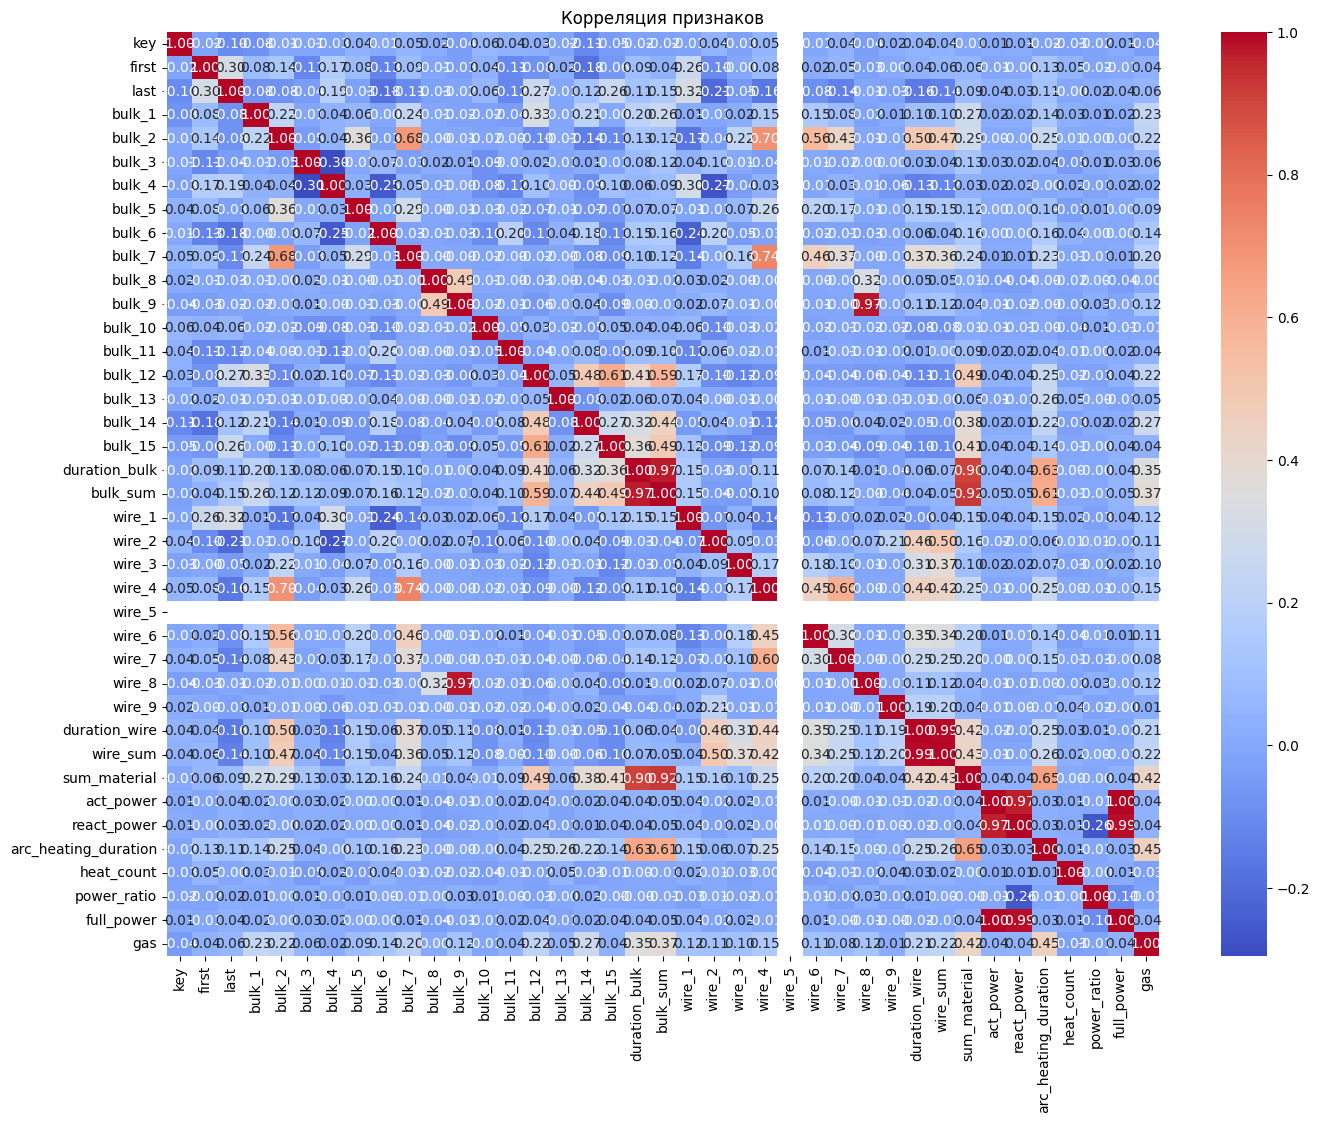

In [193]:
corr_matrix = data.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция признаков')
plt.show()


Имеются высоко кореллирующие признаки. Такая мультиколлинеарность может отрицательно сказаться на простой модели типа Линейной регрессиию

## Создаем тренировочные и тестовые выборки

In [214]:
# Параллельно уменьшим мультиколлинеарность признаков
#features = data.drop(['last', 'full_power', 'bulk_7', 'bulk_2'], axis = 1)

features = data.drop(['last', 'wire_5'], axis = 1)
target = data['last']
features_train, features_test, target_train, target_test= train_test_split(features, target, test_size=0.25, random_state=31123)

## Масштабируем признаки


In [216]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)
#Проверяем
print('Тестовая выборка: ', features_test.shape)
print('Тренировочная выборка: ', features_train.shape)

Тестовая выборка:  (580, 37)
Тренировочная выборка:  (1737, 37)


# Обучаем модели

In [217]:
# Создадим константную модель
model = DummyRegressor()
params = {'strategy': ['mean', 'median', 'constant'], 'constant': [0, 1, 42]}  
grid_search = GridSearchCV(model, params, cv=2, scoring='neg_mean_absolute_error')
grid_search.fit(features_train, target_train)
print('Best Score константной модели:', -grid_search.best_score_)

Best Score константной модели: 7.9832949308755765


## Ridge регрессия

Чтобы мультиколлинеарность не сильно влияла, возьмем модель с регуляризацией

In [218]:
params = {'fit_intercept': [True, False]}
ridge_model = Ridge(alpha=0.01)  # Задаем параметр регуляризации alpha
grid_search_lr = GridSearchCV(ridge_model, params, cv=2, scoring='neg_mean_absolute_error')
grid_search_lr.fit(features_train, target_train)
best_lr = grid_search_lr.best_estimator_
print('MAE of the Best Model on Test Data:', -grid_search_lr.best_score_)

MAE of the Best Model on Test Data: 7.611235078485887


## Catboost

In [219]:
params = {'n_estimators': [50,150,250,500],
            'loss_function': ['MAE'],
            'max_depth': [3,5,9],
             'random_state':[31123],
             'verbose':[False]}
CatBoost = CatBoostRegressor()

GridSearch_cb = GridSearchCV(CatBoost, params, cv=2, scoring='neg_mean_absolute_error')

In [220]:
%%time
GridSearch_cb.fit(features_train, target_train)


CPU times: user 1min 3s, sys: 5 s, total: 1min 8s
Wall time: 13.6 s


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x28bc49010>,
             param_grid={'loss_function': ['MAE'], 'max_depth': [3, 5, 9],
                         'n_estimators': [50, 150, 250, 500],
                         'random_state': [31123], 'verbose': [False]},
             scoring='neg_mean_absolute_error')

In [221]:

best_cb = GridSearch_cb.best_estimator_
predicted= best_cb.predict(features_train)
print('Catboost best_score_: ', -GridSearch_cb.best_score_)
print('Лучшие параметры Catboost: ', GridSearch_cb.best_params_)
#print('Catboost MAE: ', mean_absolute_error(target_train, predicted))

Catboost best_score_:  6.739229222298965
Лучшие параметры Catboost:  {'loss_function': 'MAE', 'max_depth': 5, 'n_estimators': 500, 'random_state': 31123, 'verbose': False}


## RandomForestRegressor

In [222]:
params = {'n_estimators': [50, 100, 150],
             'max_features' : list(range(1,20, 2)),
             'max_depth' : [2,7],
             'min_samples_leaf': [2, 20, 2],
             'random_state':[31123]}
RF = RandomForestRegressor()
GridSearch_rf = GridSearchCV(RF, params, cv=2, scoring='neg_mean_absolute_error')

In [223]:
%%time
GridSearch_rf.fit(features_train, target_train)

CPU times: user 36.6 s, sys: 93.9 ms, total: 36.7 s
Wall time: 36.8 s


GridSearchCV(cv=2, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 7],
                         'max_features': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'min_samples_leaf': [2, 20, 2],
                         'n_estimators': [50, 100, 150],
                         'random_state': [31123]},
             scoring='neg_mean_absolute_error')

In [224]:
best_rf= GridSearch_rf.best_estimator_

predicted_rf = best_rf.predict(features_train)
print('RandomForestRegressor best_score_: ', -GridSearch_rf.best_score_)
print('Лучшие параметры RandomForestRegressor: ', GridSearch_rf.best_params_)
#print('RandomForest MAE on Training Data: ', mean_absolute_error(target_train, predicted_rf))

RandomForestRegressor best_score_:  6.961064519047387
Лучшие параметры RandomForestRegressor:  {'max_depth': 7, 'max_features': 19, 'min_samples_leaf': 2, 'n_estimators': 100, 'random_state': 31123}


## Вывод

Линейная регрессия чуть лучше константной модели, но из-за мультиколлинеарности призанков не справляется.

Лучшей моделью из рассматриваемых оказалась Catboost.


## Проверяем лучшую модель на тестовой выборке

In [225]:
%%time
predicted = best_cb.predict(features_test)
print('Лучшая модель Catboost MAE на тестовой выборке: ', mean_absolute_error(target_test, predicted))

Лучшая модель Catboost MAE на тестовой выборке:  6.70673770535794
CPU times: user 2.44 ms, sys: 1.82 ms, total: 4.26 ms
Wall time: 2.17 ms


# Общий вывод и рекомендации заказчику

Была поставлена задача постройки модели для определения финального значения температуры сплава.

В процессе предобработки данных мы обнаружили выбросы, пропуски и несоответствия типов данных. Данные прошли предобработку. Для улучшения результативности модели было добавлено 7 дополнительных признаков из имеющихся данных.

Обучили три модели. Лучшая модель - Catboost c MAE 6.7 На тестовой выборке.

График представленный под данным отчетом подсказывает на какие добавки и особенности техпроцесса стоит обратить внимание, для получения нужной температуры.
В лидерах:

**Особенности тех процесса:**
* Начальная температура;
* Суммарная длительность нагрева электрической дугой;
* Длительность продувки сплава газом.

**Добавки:**
* Проволочная добавка под номером 1
* Сыпучие добавки 12, 14, 15

Практически не влияют на процесс достижения нужной температуры:

**Проволочные добавки:** 3, 4, 5, 8, 9

**Cыпучие добавки добавки:** 2, 5, 8, 9

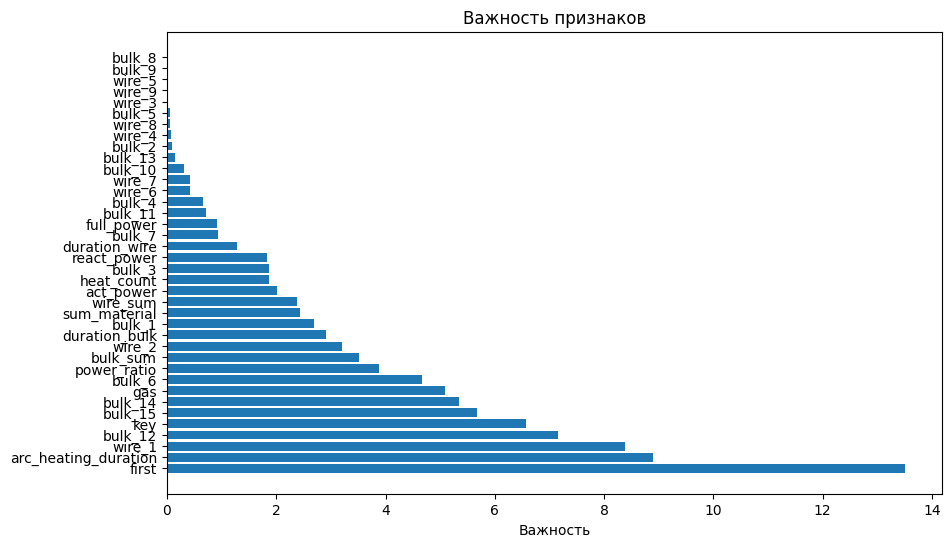

In [149]:
best_cb.fit(features, target)
feature_importance = best_cb.get_feature_importance()

FI_df = pd.DataFrame({'feature': features.columns, 'importance': feature_importance})
FI_df = FI_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(FI_df['feature'], FI_df['importance'])
plt.xlabel('Важность')
plt.title('Важность признаков')
plt.show()